In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates how to create a basic application in PODPAC, and run it in the cloud. It uses SMAP data and TWI data to create a TOPMODEL-based downscaling algorithm

## Notes
This notebook is meant to serve as inspiration for creating new applications. It will likely not run for most users. This is because of 2 reasons:

1. This notebook uses our settings files where we recorded our own Earth Data Login username and password. Unless you did the same, the SMAP node will not be authenticated. Look at the [retrieving-SMAP-data.ipynb](../basic_examples/retrieving-SMAP-data.ipynb) notebook for information. 
2. This notebook uses our settings files to retrieve the URL for our WCS server. See the line: `podpac.core.utils.load_setting('WCS_URL')` and `podpac.core.utils.load_setting('TWI')`. We saved this custom setting to our settings file for convenience. You can do something similar to retrieve data from your own, or another public WCS server. 

# PODPAC Soil Moisture Downscaling Application
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`

# Setup

In [2]:
import podpac  # Make the “PODPAC” library available to Python
# Set the WCS_URL and TWI settings
#podpac.settings['WCS_URL'] = 'URL TO WCS SERVER'
#podpac.settings['TWI_LAYER'] = 'TWI LAYER NAME ON WCS SERVER'

# Create nodes to access basic data sources

In [3]:
# Create podpac nodes for accessing data via OpenDAP from the 
# National Snow and Ice Datacenter (NSIDC)
smap = podpac.datalib.smap.SMAP(interpolation='bilinear')
wilt = podpac.datalib.smap.SMAPWilt(interpolation='bilinear')
porosity = podpac.datalib.smap.SMAPPorosity(interpolation='bilinear')
# Create podpac node to access topographic wetness index (TWI) via 
# WCS from a private server
twi = podpac.data.WCS(source=podpac.settings['WCS_URL'], 
                      layer_name=podpac.settings['TWI'],
                      interpolation='nearest')

# Create node derived from base TWI

In [3]:
# Reproject high resolution TWI onto low resolution SMAP grid
twi_bar = podpac.data.ReprojectedSource(source=twi, 
                                        reprojected_coordinates=smap.shared_coordinates,       
                                        interpolation='bilinear')

# Create downscaling algorithm using all previously-created nodes
$\theta = \Theta_{SMAP} + \frac{\rho - \Theta_w}{\kappa}(\lambda - \bar \lambda)$

In [3]:
# Create downscaling algorithm
downscaled_sm = podpac.algorithm.Arithmetic(
    A=smap, B=twi, C=twi_bar, D=porosity, E=wilt, 
    eqn='A + (D - E) / 13.0 * (B - C) ')

# Create coordinates and evaluate node on local workstation

In [ ]:
# Create arbitrary set of coordinates
coordinates = podpac.Coordinates([podpac.clinspace(41, 40., 916), 
                                  podpac.clinspace(-77,-76, 916),  
                                  '2017-09-03T12:00:00'],
                                  dims=['lat', 'lon', 'time'])
# Evaluate locally
downscaled_soil_moisture = downscaled_sm.eval(coordinates)

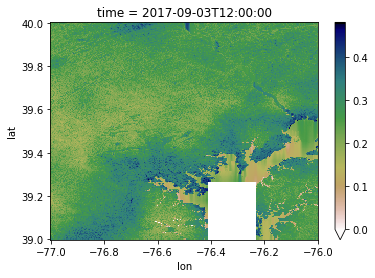

In [4]:
# Plot the results
downscaled_soil_moisture.plot(cmap='gist_earth_r', vmin=0)

# Seamless transition local evaluation to cloud evaluation

In [ ]:
# Evaluate on AWS
lambda_node = podpac.core.managers.aws_lambda.Lambda(source=downscaled_sm)
downscaled_soil_moisture = lambda_node.eval(coordinates)

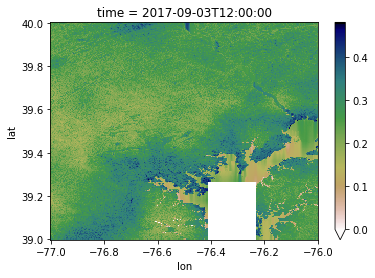

In [9]:
downscaled_soil_moisture.plot(cmap='gist_earth_r', vmin=0)